# Understanding how to correcltly grid sample an image

Going back to simple examples to get why warped images fail to appear correctly

In [4]:
## Necessary imports 

import extract_colmap as c
import numpy as np
import torch 
import os
import cv2

import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

#ghost_city_bin_path='raw/test/bin_files/ghost_city_bins/images.bin'
#medium_structure_bin_path='raw/test/bin_files/medium_structure_bins/images.bin'

ghost_city_bin_path='/home/data/Ines/models/raw/test/bin_files/ghost_city_bins/images.bin'
medium_structure_bin_path='/home/data/Ines/models/raw/test/bin_files/medium_structure_bins/images.bin'
thermitiere_bin_path='/home/data/Ines/models/raw/train/bin_files/thermitiere_bins/images.bin'
old_cliff_bin_path='/home/data/Ines/models/raw/train/bin_files/old_rainbow_cliff_bins/images.bin'

test_bin_paths=[ghost_city_bin_path, medium_structure_bin_path]
train_bin_paths=[old_cliff_bin_path, thermitiere_bin_path]



# Test grid sample with a single image

In [5]:
# Apply a ratio to a modified image

def apply_ratio(h, w, h_new, w_new, K):
    """Apply necessary changes to K, in order to match the reshape operation"""
    try:
        K[:,0,:]*=w_new/w
        K[:,1,:]*=h_new/h
    except:
        print('Probably a shape error occured')
    return K
        



In [6]:

img1 = np.array(Image.open('/home/data/Ines/models/raw/test/images/ghost_city_20220510T222046.000Z.jpg'))
dm1=np.array(Image.open('/home/data/Ines/models/raw/test/depth_maps/ghost_city_depth_20220510T222046.000Z.png'))
dm2=np.array(Image.open('/home/data/Ines/models/raw/test/depth_maps/ghost_city_depth_20220510T222051.000Z.png'))
img2=np.array(Image.open('/home/data/Ines/models/raw/test/images/ghost_city_20220510T222051.000Z.jpg'))


new_shape=(256, 128)

ratio_x=np.shape(img1)[0]/new_shape[0]
ratio_y=np.shape(img1)[1]/new_shape[1]

dm1=cv2.resize(dm1, new_shape, interpolation=cv2.INTER_NEAREST)
dm2=cv2.resize(dm2, new_shape, interpolation=cv2.INTER_NEAREST)
img1=cv2.resize(img1, new_shape, interpolation=cv2.INTER_NEAREST)
img2=cv2.resize(img2, new_shape, interpolation=cv2.INTER_NEAREST)

#PROBLEM OF UNIT?
# PROBLEM WITH TOTENSOR() ? --> putting values btw 0 and 1 == >bad sampling afterwards 
# DM= mm
# K params mm or pixels ?
# T values (colmap + quaternion --> pose matrix) the values seem to indicate m
#

# idea = put all values in meters --> but at the same time value smaller ==> can encounter truncature problem + less detail with projection with matrices... which option?

### TO DO = test when putting everything in mm and not meters
## Check value coherence with Maxime the boss

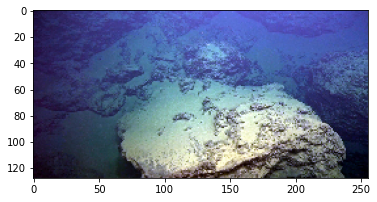

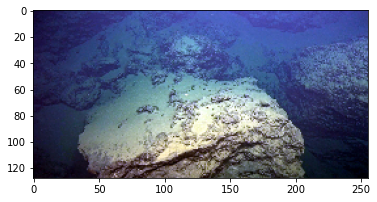

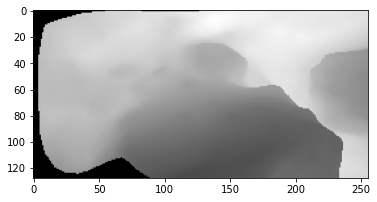

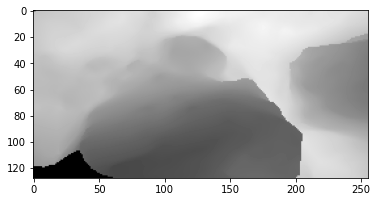

In [7]:
# check depth maps 

plt.imshow(img1)
plt.figure()
plt.imshow(img2)
plt.figure()
plt.imshow(dm1, cmap='gray')
plt.figure()
plt.imshow(dm2, cmap='gray')

In [8]:
print(img1[64,128,:])

[142 201 199]


In [9]:
## PARAMETERS 
width=256
height=128
initial_width=1876
initial_height=1052

## CAMERA INTRISICS
batch_size=1
K=torch.from_numpy(np.ones((batch_size,3,3))).type(torch.FloatTensor)
for i in range(batch_size):
    #K[i,:,:]=torch.from_numpy(np.array([[682.345,  0,       491.617], 
                                        #[0,        685.004, 276.348],
                                        #[0,        0,             1]]))

    K[i,:,:]=torch.from_numpy(np.array([[1339.87,  0.0,       962.58], 
                                        [0.0,      1340.59,   531.40],
                                        [0.0,        0.0,        1.0]]))


apply_ratio(initial_height, initial_width,height, width,K)
print('new K', K)



inv_K=torch.from_numpy(np.linalg.inv(K)).type(torch.FloatTensor)

## DEVICE

device=torch.device("cuda")
K=K.type(torch.cuda.FloatTensor)
inv_K=inv_K.type(torch.cuda.FloatTensor)

## IMGS TO TENSOR + DEVICE

transform=T.ToTensor()
#img1=torch.from_numpy(img1)
#img2=torch.from_numpy(img2)



## SIZE



#OTHER
eps=1e-7

new K tensor([[[182.8394,   0.0000, 131.3542],
         [  0.0000, 163.1136,  64.6570],
         [  0.0000,   0.0000,   1.0000]]])


In [10]:
## EVERYTHING ON THE SAME UNIT = METERS

dm1=dm1/1000.0
dm2=dm2/1000.0


#T, inv_T already in meters according to the information given by Colmap.


In [11]:
# Pixel vectors 
meshgrid = np.meshgrid(range(width), range(height), indexing='xy')
id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
id_coords = nn.Parameter(torch.from_numpy(id_coords),
                                      requires_grad=False)

ones = torch.ones(batch_size, 1,  height *  width).type(torch.cuda.FloatTensor)

pix_coords = torch.unsqueeze(torch.stack(
[ id_coords[0].view(-1),  id_coords[1].view(-1)], 0), 0)

pix_coords =  pix_coords.repeat(batch_size, 1, 1).type(torch.cuda.FloatTensor)
pix_coords =torch.cat([ pix_coords,  ones], 1)
print(pix_coords.size())
print(pix_coords[:,:,2])

torch.Size([1, 3, 32768])
tensor([[2., 0., 1.]], device='cuda:0')


In [12]:
cam_points = torch.matmul(inv_K, pix_coords)
print(cam_points)

tensor([[[-0.7184, -0.7129, -0.7075,  ...,  0.6653,  0.6708,  0.6763],
         [-0.3964, -0.3964, -0.3964,  ...,  0.3822,  0.3822,  0.3822],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]]],
       device='cuda:0')


Initial pixel: p= (p_x, p_y, 1)
Projection in the cam ref: P_c=(x_c, y_c, 1)
x_c<0, y_c<0 ? 

In [ ]:
print(width)
print(height)

256
128


In [ ]:
dm1=torch.from_numpy(dm1)

if len(dm1.size())!=3:
    dm1=dm1.unsqueeze(0)

dm1=dm1.type(torch.cuda.FloatTensor)
cam_points1 = dm1.view(batch_size, 1, -1) * cam_points.type(torch.cuda.FloatTensor)

In [ ]:
print(dm1.size())

torch.Size([1, 128, 256])


In [ ]:
print(cam_points1[:,:,6*4])
print(cam_points1[:,:,32*20])
print(cam_points1[:,:,128*64])

tensor([[-0., -0., 0.]], device='cuda:0')
tensor([[-0.1678, -3.5136,  9.1470]], device='cuda:0')
tensor([[-0., -0., 0.]], device='cuda:0')


In [ ]:
cam_points1 = torch.cat([cam_points1, ones], 1)
print(cam_points1.size())
print(cam_points1[:,:,564])
# point 564 values in the cam ref. Which unit ? meters --> nonsensical

torch.Size([1, 4, 32768])
tensor([[-3.4851, -3.0846,  8.0300,  1.0000]], device='cuda:0')


In [ ]:
## Right values 
## IMG 1
##CHECK TINV VALUES (WORLD--> CAM)
T_inv1=np.array([[ 9.62124827e-01,  2.71629800e-01, -2.30882819e-02, -2.58623899e+01],
 [ 1.84646765e-01, -7.11642995e-01, -6.77842031e-01,  1.24432007e+01],
 [-2.00552710e-01,  6.47905470e-01, -7.34844958e-01,  4.53820553e+00]])

## *********************
##CHECK T VALUES (CAM --> WORLD)
T1=np.array([[ 0.96212483,  0.18464676, -0.20055271, 23.49540008],
 [ 0.2716298,  -0.711643,    0.64790547, 12.9397842 ],
 [-0.20055271, -0.67784203, -0.73484496, 11.17228371]])

 ## IMG 2

##*********************
##CHECK TINV VALUES (WORLD--> CAM)
T_inv2=np.array([[ 9.61212758e-01,  2.75100265e-01, -1.97453066e-02, -2.58964661e+01],
 [ 1.90533011e-01, -7.14081132e-01, -6.73635887e-01,  1.26656769e+01],
 [-1.99417162e-01,  6.43745276e-01, -7.38799577e-01,  4.91454295e+00]])
##*********************
##CHECK T VALUES (CAM --> WORLD)
T2=np.array([[ 0.96121276,  0.19053301, -0.19941716, 23.45882829],
 [ 0.27510026, -0.71408113,  0.64374528, 13.00473176],
 [-0.19941716, -0.67363589, -0.73879958, 11.65158307]])


T1=torch.from_numpy(T1).type(torch.cuda.FloatTensor)
T_inv1=torch.from_numpy(T_inv1).type(torch.cuda.FloatTensor)

T2=torch.from_numpy(T2).type(torch.cuda.FloatTensor)
T_inv2=torch.from_numpy(T_inv2).type(torch.cuda.FloatTensor)

In [ ]:
print(cam_points1.size())
print(T1.size())

world1=torch.matmul(T1, cam_points1)
print(world1.size())
print('test')
print('world ref', world1[:,:,0])
print('cam ref', cam_points[:,:,0])
print('test another point')
print(world1[:,:,28])
print('cam ref', cam_points[:,:,28])


T_inv1=T_inv1.type(torch.cuda.FloatTensor)

T_inv2=T_inv2.type(torch.cuda.FloatTensor)

torch.Size([1, 4, 32768])
torch.Size([3, 4])
torch.Size([1, 3, 32768])
test
world ref tensor([[23.4954, 12.9398, 11.1723]], device='cuda:0')
cam ref tensor([[-0.7184, -0.3964,  1.0000]], device='cuda:0')
test another point
tensor([[23.4954, 12.9398, 11.1723]], device='cuda:0')
cam ref tensor([[-0.5653, -0.3964,  1.0000]], device='cuda:0')


In [ ]:
## NEW TEST PUTTING EVERYTHING IN MM

#T1=T1*1000
#T_inv1=T_inv1*1000

In [ ]:
#CHECKS
P = torch.matmul(K, T_inv2)
print('****************************')
print('K', K)
print('****************************')
print('T_inv1', T_inv1)
print('****************************')
print('T1', T1)
print('****************************')
print(' P size', P.size())
print('P', P)
print('****************************')
print('world1 size', world1.size())

****************************
K tensor([[[182.8394,   0.0000, 131.3542],
         [  0.0000, 163.1136,  64.6570],
         [  0.0000,   0.0000,   1.0000]]], device='cuda:0')
****************************
T_inv1 tensor([[ 9.6212e-01,  2.7163e-01, -2.3088e-02, -2.5862e+01],
        [ 1.8465e-01, -7.1164e-01, -6.7784e-01,  1.2443e+01],
        [-2.0055e-01,  6.4791e-01, -7.3484e-01,  4.5382e+00]], device='cuda:0')
****************************
T1 tensor([[ 0.9621,  0.1846, -0.2006, 23.4954],
        [ 0.2716, -0.7116,  0.6479, 12.9398],
        [-0.2006, -0.6778, -0.7348, 11.1723]], device='cuda:0')
****************************
 P size torch.Size([1, 3, 4])
P tensor([[[ 1.4955e+02,  1.3486e+02, -1.0065e+02, -4.0893e+03],
         [ 1.8185e+01, -7.4854e+01, -1.5765e+02,  2.3837e+03],
         [-1.9942e-01,  6.4375e-01, -7.3880e-01,  4.9145e+00]]],
       device='cuda:0')
****************************
world1 size torch.Size([1, 3, 32768])


In [ ]:
## CHECKING WHAT PROJECT3D GIVES WORLD REF ---> pix ref

# Negative values in cam extrinsics and intrinsics ?
ones = torch.ones(1, 1, 128*256).type(torch.cuda.FloatTensor)

points_world_ref1= torch.cat([world1, ones], 1)

print(points_world_ref1.size())


pix_ref=torch.matmul(P, points_world_ref1)

print('****************************')
print('Coordinates of the middle point in world coordinates')
print(points_world_ref1[:,:,64*128])

print('****************************')
print('Coordinates of another point')
print(points_world_ref1[:,:,250*3])

#points_new_cam_ref=torch.matmul(P, points_world_ref1)
#print(points_new_cam_ref[:,128,64,:])

pix_coords = pix_ref[:, :2, :] / (pix_ref[:, 2, :].unsqueeze(1) + eps)

s1_pix=pix_coords 

print('pix_coords size before view', pix_coords.size())

print(pix_coords)

# concat ones ? (X, Y, Z, 1)


pix_coords = pix_coords.view(batch_size, 2, height, width) # size [1,2,128,256]
pix_coords = pix_coords.permute(0, 2, 3, 1) # size [1,128,256,2]


#pix = (x,y)

pix_coords[...,0]/= 256.0 # get better informed  on this syntax.
pix_coords[..., 1] /= 128.0

s2_pix=pix_coords

pix_coords = (pix_coords - 0.5)* 2

print('****************************')
print('projection of the middle pixel in the new pix plane')
print(pix_coords[:,127,64,:])
print('projection of the other point in the new pix plane')
print(pix_coords[:,43,250,:])
print(pix_coords.size())

torch.Size([1, 4, 32768])
****************************
Coordinates of the middle point in world coordinates
tensor([[23.4954, 12.9398, 11.1723,  1.0000]], device='cuda:0')
****************************
Coordinates of another point
tensor([[26.0454, 22.4433,  5.9664,  1.0000]], device='cuda:0')
pix_coords size before view torch.Size([1, 2, 32768])
tensor([[[147.3902, 147.3902, 147.3902,  ..., 239.9440, 240.7604, 241.5753],
         [265.8553, 265.8553, 265.8553,  ..., 137.7388, 137.7973, 137.8564]]],
       device='cuda:0')
****************************
projection of the middle pixel in the new pix plane
tensor([[0.1515, 3.1540]], device='cuda:0')
projection of the other point in the new pix plane
tensor([[0.8501, 0.0296]], device='cuda:0')
torch.Size([1, 128, 256, 2])


In [ ]:
print(pix_coords[:,3,126,:])

tensor([[-0.0080, -0.8486]], device='cuda:0')


In [ ]:
### pix coords from im1 projected in im 2 --> sampling from im1 pixels from im1 projected in the im2 ref then comparison with the pixels of im2
img2=torch.from_numpy(img2)
#img1=torch.from_numpy(img1)

if len(img2.size())!=4:
    img2=img2.unsqueeze(0)

if len(img1.size())!=4:
    img1=img1.unsqueeze(0)


img1=img1.type(torch.cuda.FloatTensor)
img2=img2.type(torch.cuda.FloatTensor)
pix_coords=pix_coords.type(torch.cuda.FloatTensor)


print(img1.size())
#print(im1.size())
print(pix_coords.size())

im1=torch.transpose(img1,1,3)
im1=torch.transpose(im1,2,3)


im2=torch.transpose(img2,1,3)
im2=torch.transpose(im2,2,3)

wrp_img=F.grid_sample(im1, pix_coords, padding_mode="border", align_corners=False)

wrp_img=wrp_img.transpose(1,3)
print(wrp_img.size())
wrp_img=wrp_img.transpose(1,2)

wrp_img=wrp_img.type(torch.IntTensor)
print(wrp_img.size())


plt.imshow(wrp_img.cpu().numpy().squeeze())

TypeError: 'int' object is not callable

# Testing other types of out of bound values management

Zero padding

torch.Size([1, 256, 128, 3])
torch.Size([1, 128, 256, 3])
img1 reprojected in img2


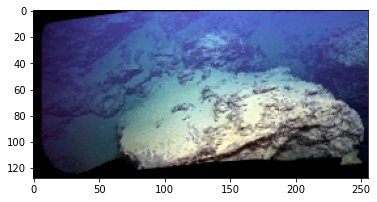

In [ ]:
wrp_img2=F.grid_sample(im1, pix_coords, padding_mode="zeros", align_corners=False)
wrp_img2=wrp_img2.transpose(1,3)
print(wrp_img2.size())
wrp_img2=wrp_img2.transpose(1,2)

wrp_img2=wrp_img2.type(torch.IntTensor)
print(wrp_img2.size())

print('img1 reprojected in img2')
plt.imshow(wrp_img2.cpu().numpy().squeeze())

Reflection

torch.Size([1, 256, 128, 3])
torch.Size([1, 128, 256, 3])


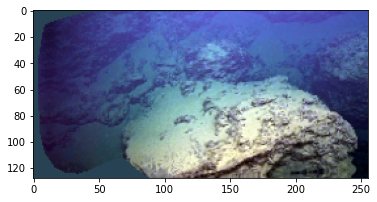

In [ ]:
wrp_img3=F.grid_sample(im1, pix_coords, padding_mode="reflection", align_corners=False)
wrp_img3=wrp_img3.transpose(1,3)
print(wrp_img3.size())
wrp_img3=wrp_img3.transpose(1,2)

wrp_img3=wrp_img3.type(torch.IntTensor)
print(wrp_img3.size())

plt.imshow(wrp_img3.cpu().numpy().squeeze())

Analysis: out of bound values where there was no data in the depth map --> OK. But right no data rectangle?  Geometrical explanation? Movement of the cam? + only upper part of the image reprojected --> weird.

In [ ]:
print(im1[:,:,64,128])
print(wrp_img[:,64,128,:])

tensor([[142., 201., 199.]], device='cuda:0')
tensor([[ 81, 101, 195]], dtype=torch.int32)


# Building a single function which repojects +  wrap, + visualisation

In [ ]:
def generate_wrp_image(im1, dm1, T1, Tinv2, K, inv_K):
    """Projects the pixels of im1 to im2 and creates a warped img thanks to a sampling from im1
    INPUTS 
    im1, Tensor, size [batch_size, 3, width, ]
    dm1, 
    Tinv2, 
    K,
    inv_K = Tensors
    OUPTUT
    """
    
    ### FROM PIXEL TO CAM1 REF###################################################################
    # Creation of the pix coordinates 
    meshgrid = np.meshgrid(range(width), range(height), indexing='xy')
    id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
    id_coords = nn.Parameter(torch.from_numpy(id_coords),
                                      requires_grad=False)

    ones = torch.ones(batch_size, 1,  height *  width).type(torch.cuda.FloatTensor)

    pix_coords = torch.unsqueeze(torch.stack(
    [ id_coords[0].view(-1),  id_coords[1].view(-1)], 0), 0)

    pix_coords =  pix_coords.repeat(batch_size, 1, 1).type(torch.cuda.FloatTensor)
    pix_coords =torch.cat([ pix_coords,  ones], 1)

    #Projection in CAM1 ref
    cam_points = torch.matmul(inv_K, pix_coords)
    print('dm1', dm1)
    cam_points= dm1.view(batch_size, 1, -1) * cam_points.type(torch.cuda.FloatTensor)

    #############################################################################################
    ## FROM CAM1 ref to WORLD ref
    world1=torch.matmul(T1, cam_points1)
    points_world_ref1= torch.cat([world1, ones], 1)

    #############################################################################################
    ### FROM WORLD ref to PIX ref in CAM2
    P=torch.matmul(K, Tinv2)
    pix_ref=torch.matmul(P, points_world_ref1)
    pix_coords = pix_ref[:, :2, :] / (pix_ref[:, 2, :].unsqueeze(1) + eps)
    pix_coords = pix_coords.view(batch_size, 2, height, width) # size [1,2,128,256]
    pix_coords = pix_coords.permute(0, 2, 3, 1) # size [1,128,256,2]
    pix_coords[...,0]/= width 
    pix_coords[..., 1] /= height
    pix_coords = (pix_coords - 0.5)* 2

    ############################################################################################
    ## WARPED IMAGE GENERATION
    im1=torch.transpose(img1,1,3) # avoid extra allocation
    im1=torch.transpose(im1,2,3)
    wrp_img=F.grid_sample(im1, pix_coords, padding_mode="zeros", align_corners=False)
    wrp_img=wrp_img.type(torch.IntTensor)

    return wrp_img


In [ ]:
def display_img(tensor_img):
    tensor_img=tensor_img.transpose(1,3)
    tensor_img=tensor_img.transpose(1,2)
    plt.imshow(tensor_img.cpu().numpy().squeeze())

In [ ]:
test=generate_wrp_image(img1, dm1, T1, T_inv2, K, inv_K)
display_img(test)

dm1 tensor([[[0.0000, 0.0000, 0.0000,  ..., 8.6460, 8.6470, 8.6410],
         [0.0000, 0.0000, 0.0000,  ..., 8.6470, 8.6470, 8.6350],
         [0.0000, 0.0000, 0.0000,  ..., 8.6500, 8.6490, 8.6440],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 8.2980, 8.2820, 8.2600],
         [0.0000, 0.0000, 0.0000,  ..., 8.2850, 8.2680, 8.2470],
         [0.0000, 0.0000, 0.0000,  ..., 8.2630, 8.2500, 8.2360]]],
       device='cuda:0')


TypeError: transpose() received an invalid combination of arguments - got (numpy.ndarray, int, int), but expected one of:
 * (Tensor input, int dim0, int dim1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, int, int)
 * (Tensor input, name dim0, name dim1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !int!, !int!)


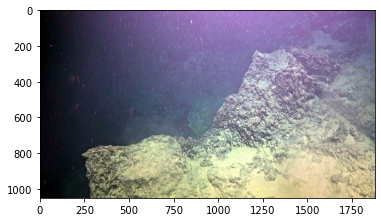

In [ ]:
# Test with other images:

img1 = np.array(Image.open('/home/data/Ines/models/raw/test/images/ghost_city_20220510T223211.000Z.jpg'))
dm1=np.array(Image.open('/home/data/Ines/models/raw/test/depth_maps/ghost_city_depth_20220510T223216.000Z.png'))
dm2=np.array(Image.open('/home/data/Ines/models/raw/test/depth_maps/ghost_city_depth_20220510T223211.000Z.png'))
img2=np.array(Image.open('/home/data/Ines/models/raw/test/images/ghost_city_20220510T223216.000Z.jpg'))

plt.imshow(img1)

new_shape=(256, 128)

ratio_x=np.shape(img1)[0]/new_shape[0]
ratio_y=np.shape(img1)[1]/new_shape[1]

dm1=cv2.resize(dm1, new_shape, interpolation=cv2.INTER_NEAREST)
dm2=cv2.resize(dm2, new_shape, interpolation=cv2.INTER_NEAREST)
img1=cv2.resize(img1, new_shape, interpolation=cv2.INTER_NEAREST)
img2=cv2.resize(img2, new_shape, interpolation=cv2.INTER_NEAREST)

#dm1/=1000
#dm2/=1000

img1=torch.from_numpy(img1).unsqueeze(0).type(torch.cuda.FloatTensor)
dm1=torch.from_numpy(dm1).unsqueeze(0).type(torch.cuda.FloatTensor)

dm1 tensor([[[   0.,    0.,    0.,  ..., 5876., 5894., 5916.],
         [   0.,    0.,    0.,  ..., 5872., 5892., 5914.],
         [   0.,    0.,    0.,  ..., 5868., 5890., 5912.],
         ...,
         [   0.,    0.,    0.,  ..., 3376., 3367., 3359.],
         [   0.,    0.,    0.,  ..., 3368., 3359., 3350.],
         [   0.,    0.,    0.,  ..., 3360., 3351., 3342.]]], device='cuda:0')


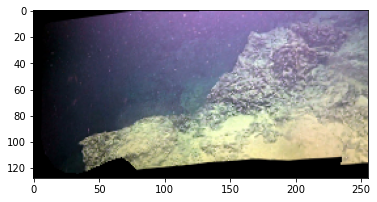

In [ ]:
test2=generate_wrp_image(img1, dm1, T1, T_inv2, K, inv_K)
display_img(test2)

In [ ]:
## Finally :')

## Method with the T_i_j matrix

In [ ]:
T1=T1.unsqueeze(0)
T2=T2.unsqueeze(0)

In [ ]:
def product_pose_matrices(T1, T2):
    # goal add a line of 0s and a 1 to muliply?
    last_row= torch.zeros(1, 1,  4).type(torch.cuda.FloatTensor)
    last_row[:,:,-1]=1
    print(last_row)
    T1_new=torch.cat([T1, last_row], 1)
    T2_new=torch.cat([T2, last_row], 1)
    T1_2=torch.matmul(T1_new, T2_new)
    T1_2=T1_2[:,:3,:]
    print(T1_2)
    

In [ ]:
product_pose_matrices(T1,T2)

tensor([[[0., 0., 0., 1.]]], device='cuda:0')
tensor([[[  1.0156,   0.1866,   0.0752,  46.1302],
         [ -0.0639,   0.1235,  -0.9910,  17.6063],
         [ -0.2327,   0.9408,   0.1465, -10.9097]]], device='cuda:0')


## Test with Clementin's method